In [3]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ================================
# Step 1: Feature Extraction Function with More Features
# ================================
def extract_features(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Core features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        rms = np.mean(librosa.feature.rms(y=y))

        # Extra features
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))

        # Combine all features
        combined = np.hstack((
            mfcc_scaled,
            spectral_centroid,
            spectral_bandwidth,
            zero_crossing_rate,
            rms,
            rolloff,
            chroma,
            contrast,
            tonnetz
        ))
        return combined
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# ================================
# Step 2: Define Path and Machine Types
# ================================
DATASET_PATH = r"D:\\"  # Update if needed
MACHINE_TYPES = ["fan", "pump", "gearbox"]

X_data = []
y_data = []

# ================================
# Step 3: Feature Extraction for All Audio
# ================================
for machine_type in MACHINE_TYPES:
    label = MACHINE_TYPES.index(machine_type)  # fan=0, pump=1, gearbox=2

    for data_split in ["train", "source_test", "target_test"]:
        folder = os.path.join(DATASET_PATH, machine_type, data_split)

        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".wav"):
                    file_path = os.path.join(root, file)
                    features = extract_features(file_path)
                    if features is not None:
                        X_data.append(features)
                        y_data.append(label)

print("✅ Finished loading and extracting features!")
print("Total Samples:", len(X_data))

# ================================
# Step 4: Convert to NumPy Arrays
# ================================
X_data = np.array(X_data)
y_data = np.array(y_data)

# ================================
# Step 5: Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# ================================
# Step 6: Random Forest Training
# ================================
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("✅ Random Forest Training Completed!")

# ================================
# Step 7: Evaluation
# ================================
y_pred = rf_model.predict(X_test)

print("\n🔥 Confusion Matrix (Machine Type Prediction):")
print(confusion_matrix(y_test, y_pred))

print("\n🔥 Classification Report:")
print(classification_report(y_test, y_pred, target_names=MACHINE_TYPES))


✅ Finished loading and extracting features!
Total Samples: 12851
Train Shape: (8995, 48)
Test Shape: (3856, 48)
✅ Random Forest Training Completed!

🔥 Confusion Matrix (Machine Type Prediction):
[[1179   84    0]
 [  65 1188   10]
 [   2    0 1328]]

🔥 Classification Report:
              precision    recall  f1-score   support

         fan       0.95      0.93      0.94      1263
        pump       0.93      0.94      0.94      1263
     gearbox       0.99      1.00      1.00      1330

    accuracy                           0.96      3856
   macro avg       0.96      0.96      0.96      3856
weighted avg       0.96      0.96      0.96      3856




=== Data Summary ===
Train samples: 9044
Test samples: 1962
Feature dimension: 40

=== Cross-Validation ===
Mean Accuracy: 0.91 ± 0.03

=== Test Evaluation ===
Confusion Matrix:
[[470 118  12]
 [ 56 509  35]
 [  3   1 758]]

Classification Report:
              precision    recall  f1-score   support

         fan       0.89      0.78      0.83       600
        pump       0.81      0.85      0.83       600
     gearbox       0.94      0.99      0.97       762

    accuracy                           0.89      1962
   macro avg       0.88      0.88      0.88      1962
weighted avg       0.89      0.89      0.88      1962



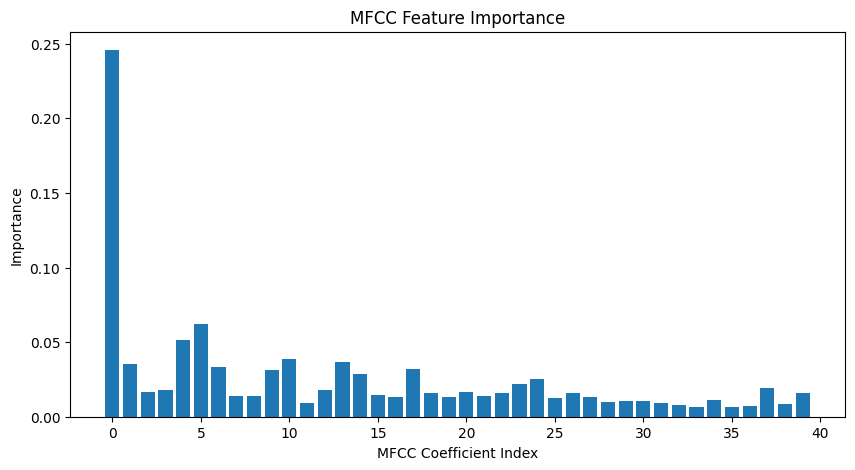

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# =============================================
# Configuration
# =============================================
DATASET_PATH = r"D:\\"  # Update with your actual path
MACHINE_TYPES = ["fan", "pump", "gearbox"]
TEST_MODE = "source_test"  # Choose: "source_test" or "target_test"

# =============================================
# Feature Extraction Function
# =============================================
def extract_features(file_path, n_mfcc=40):
    """Extract MFCC features from audio file"""
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# =============================================
# Data Loading with PROPER Train/Test Separation
# =============================================
def load_data():
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    for label, machine_type in enumerate(MACHINE_TYPES):
        # Load TRAIN data
        train_folder = os.path.join(DATASET_PATH, machine_type, "train")
        for root, _, files in os.walk(train_folder):
            for file in files:
                if file.endswith(".wav"):
                    features = extract_features(os.path.join(root, file))
                    X_train.append(features)
                    y_train.append(label)
        
        # Load TEST data (only from specified test folder)
        test_folder = os.path.join(DATASET_PATH, machine_type, TEST_MODE)
        if os.path.exists(test_folder):  # Check if test folder exists
            for root, _, files in os.walk(test_folder):
                for file in files:
                    if file.endswith(".wav"):
                        features = extract_features(os.path.join(root, file))
                        X_test.append(features)
                        y_test.append(label)
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# =============================================
# Main Pipeline
# =============================================
def main():
    # 1. Load Data
    X_train, X_test, y_train, y_test = load_data()
    
    print("\n=== Data Summary ===")
    print(f"Train samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Feature dimension: {X_train.shape[1]}")
    
    # 2. Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 3. Train Model
    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Handle class imbalance
    )
    
    # 4. Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\n=== Cross-Validation ===")
    print(f"Mean Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")
    
    # 5. Final Training
    model.fit(X_train, y_train)
    
    # 6. Evaluation
    y_pred = model.predict(X_test)
    
    print("\n=== Test Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=MACHINE_TYPES))
    
    # 7. Feature Importance
    plt.figure(figsize=(10, 5))
    plt.bar(range(X_train.shape[1]), model.feature_importances_)
    plt.title("MFCC Feature Importance")
    plt.xlabel("MFCC Coefficient Index")
    plt.ylabel("Importance")
    plt.show()

if __name__ == "__main__":
    main()

In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# ================================
# Step 1: Feature Extraction Function with More Features
# ================================
def extract_features(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        rms = np.mean(librosa.feature.rms(y=y))

        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))

        return np.hstack((
            mfcc_scaled,
            spectral_centroid,
            spectral_bandwidth,
            zero_crossing_rate,
            rms,
            rolloff,
            chroma,
            contrast,
            tonnetz
        ))
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# ================================
# Step 2: Define Path and Labels
# ================================
DATASET_PATH = r"D:\\"
MACHINE_TYPES = ["fan", "pump", "gearbox"]
X_data = []
y_data = []

# ================================
# Step 3: Extract Features
# ================================
for machine_type in MACHINE_TYPES:
    label = MACHINE_TYPES.index(machine_type)
    for data_split in ["train", "source_test", "target_test"]:
        folder = os.path.join(DATASET_PATH, machine_type, data_split)
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".wav"):
                    path = os.path.join(root, file)
                    features = extract_features(path)
                    if features is not None:
                        X_data.append(features)
                        y_data.append(label)

print("✅ Finished loading and extracting features!")
print("Total Samples:", len(X_data))

# ================================
# Step 4: Train/Test Split
# ================================
X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# ================================
# Step 5: Random Forest Hyperparameter Tuning
# ================================
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("🔍 Running Grid Search (Random Forest)...")
grid.fit(X_train, y_train)

# ================================
# Step 6: Evaluate Best Model
# ================================
print("\n✅ Best Parameters Found:")
print(grid.best_params_)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n🔥 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n🔥 Classification Report:")
print(classification_report(y_test, y_pred, target_names=MACHINE_TYPES))


✅ Finished loading and extracting features!
Total Samples: 12851
Train Shape: (8995, 48)
Test Shape: (3856, 48)
🔍 Running Grid Search (Random Forest)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Best Parameters Found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

🔥 Confusion Matrix:
[[1182   81    0]
 [  59 1199    5]
 [   2    0 1328]]

🔥 Classification Report:
              precision    recall  f1-score   support

         fan       0.95      0.94      0.94      1263
        pump       0.94      0.95      0.94      1263
     gearbox       1.00      1.00      1.00      1330

    accuracy                           0.96      3856
   macro avg       0.96      0.96      0.96      3856
weighted avg       0.96      0.96      0.96      3856



C:\Users\HP\AppData\Local\Temp\ipykernel_1392\1937668835.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


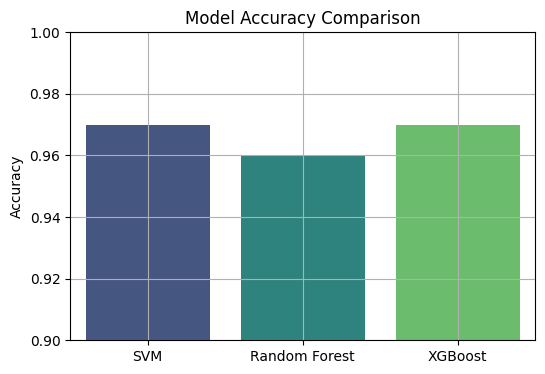

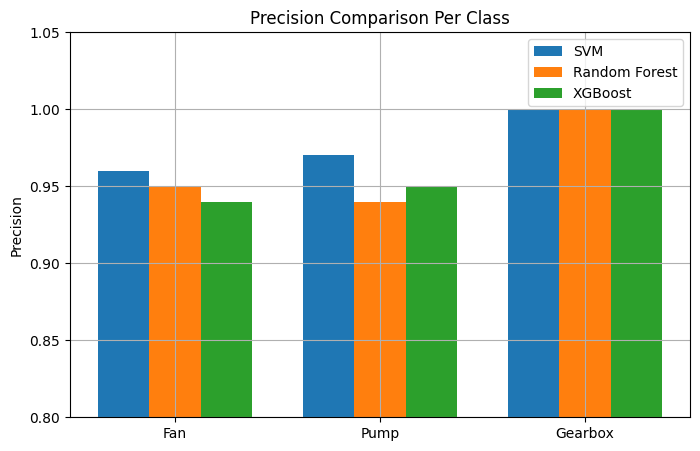

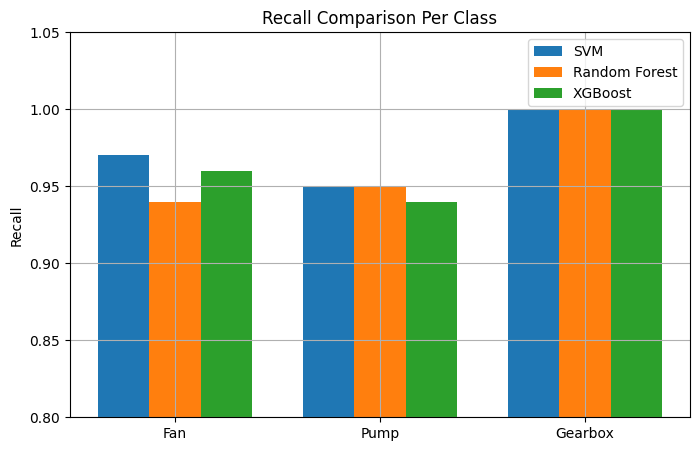

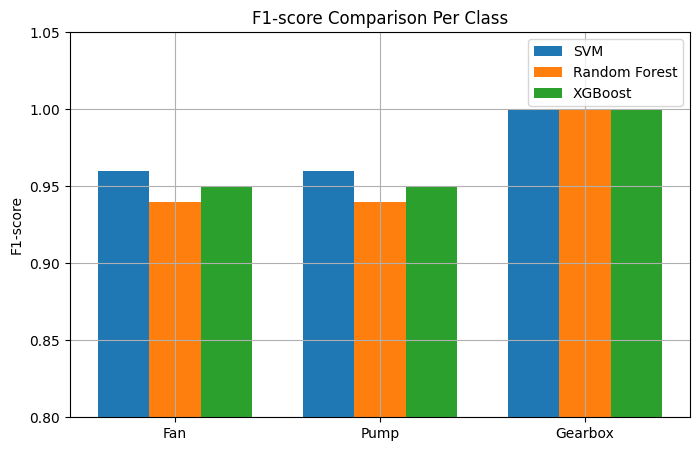

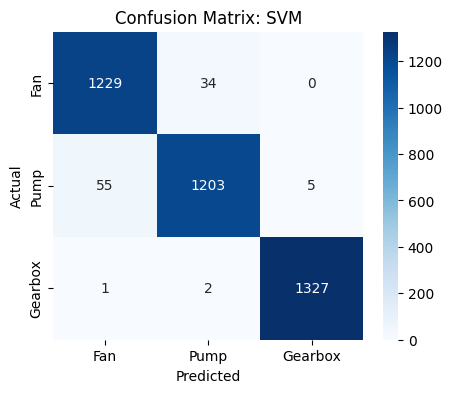

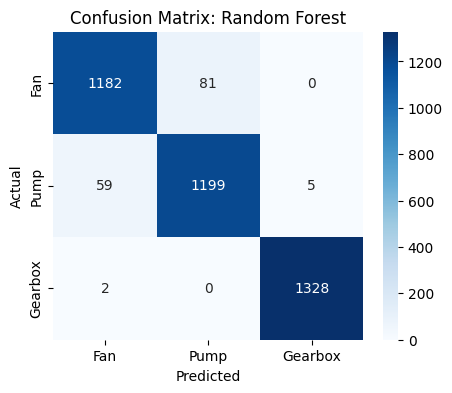

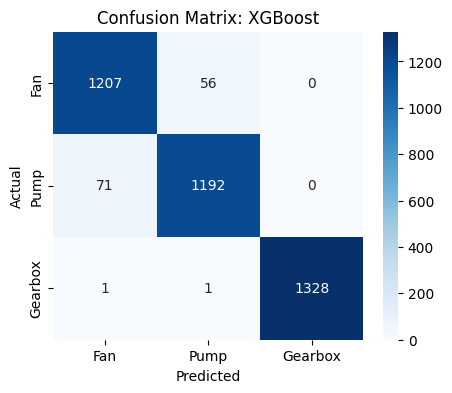

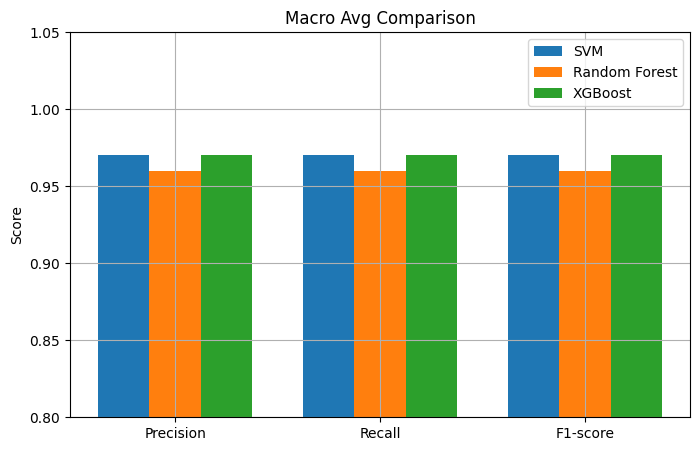

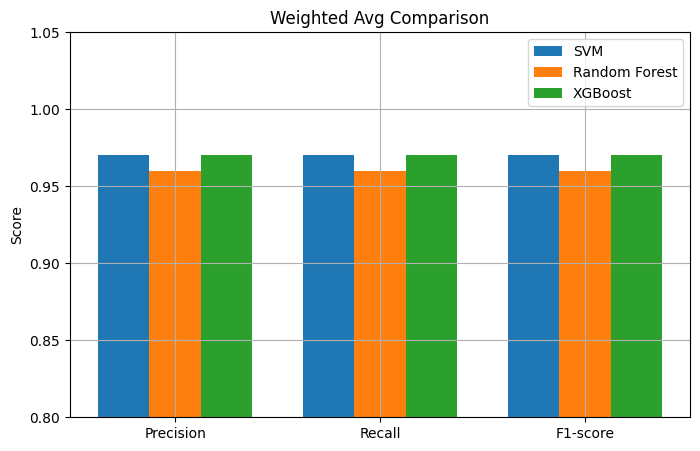

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ================================
# 1. Define Labels
# ================================
models = ["SVM", "Random Forest", "XGBoost"]
classes = ["Fan", "Pump", "Gearbox"]

# ================================
# 2. Add Your Model Results Here
# ================================
# Format: [precision, recall, f1-score] for each class

svm_report = {
    "Fan":     [0.96, 0.97, 0.96],
    "Pump":    [0.97, 0.95, 0.96],
    "Gearbox": [1.00, 1.00, 1.00],
    "Accuracy": 0.97,
    "Macro Avg": [0.97, 0.97, 0.97],
    "Weighted Avg": [0.97, 0.97, 0.97],
    "Confusion": [[1229, 34, 0], [55, 1203, 5], [1, 2, 1327]]
}

rf_report = {
    "Fan":     [0.95, 0.94, 0.94],
    "Pump":    [0.94, 0.95, 0.94],
    "Gearbox": [1.00, 1.00, 1.00],
    "Accuracy": 0.96,
    "Macro Avg": [0.96, 0.96, 0.96],
    "Weighted Avg": [0.96, 0.96, 0.96],
    "Confusion": [[1182, 81, 0], [59, 1199, 5], [2, 0, 1328]]
}

xgb_report = {
    "Fan":     [0.94, 0.96, 0.95],
    "Pump":    [0.95, 0.94, 0.95],
    "Gearbox": [1.00, 1.00, 1.00],
    "Accuracy": 0.97,
    "Macro Avg": [0.97, 0.97, 0.97],
    "Weighted Avg": [0.97, 0.97, 0.97],
    "Confusion": [[1207, 56, 0], [71, 1192, 0], [1, 1, 1328]]
}

# ================================
# 3. Bar Chart: Accuracy Comparison
# ================================
accuracies = [svm_report["Accuracy"], rf_report["Accuracy"], xgb_report["Accuracy"]]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

# ================================
# 4. Precision / Recall / F1 per Class
# ================================
for metric_idx, metric_name in enumerate(["Precision", "Recall", "F1-score"]):
    values = [
        [svm_report[class_name][metric_idx] for class_name in classes],
        [rf_report[class_name][metric_idx] for class_name in classes],
        [xgb_report[class_name][metric_idx] for class_name in classes]
    ]
    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(8, 5))
    plt.bar(x - width, values[0], width=width, label="SVM")
    plt.bar(x, values[1], width=width, label="Random Forest")
    plt.bar(x + width, values[2], width=width, label="XGBoost")
    plt.xticks(x, classes)
    plt.title(f"{metric_name} Comparison Per Class")
    plt.ylabel(metric_name)
    plt.ylim(0.8, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

# ================================
# 5. Confusion Matrix Heatmaps
# ================================
conf_matrices = [svm_report["Confusion"], rf_report["Confusion"], xgb_report["Confusion"]]

for idx, model_name in enumerate(models):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrices[idx], annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ================================
# 6. Macro & Weighted Avg Comparison
# ================================
for avg_type in ["Macro Avg", "Weighted Avg"]:
    values = [
        svm_report[avg_type],
        rf_report[avg_type],
        xgb_report[avg_type]
    ]

    x = np.arange(3)
    width = 0.25

    plt.figure(figsize=(8, 5))
    plt.bar(x - width, values[0], width=width, label="SVM")
    plt.bar(x, values[1], width=width, label="Random Forest")
    plt.bar(x + width, values[2], width=width, label="XGBoost")
    plt.xticks(x, ["Precision", "Recall", "F1-score"])
    plt.title(f"{avg_type} Comparison")
    plt.ylim(0.8, 1.05)
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_1392\1504407188.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], palette='viridis')


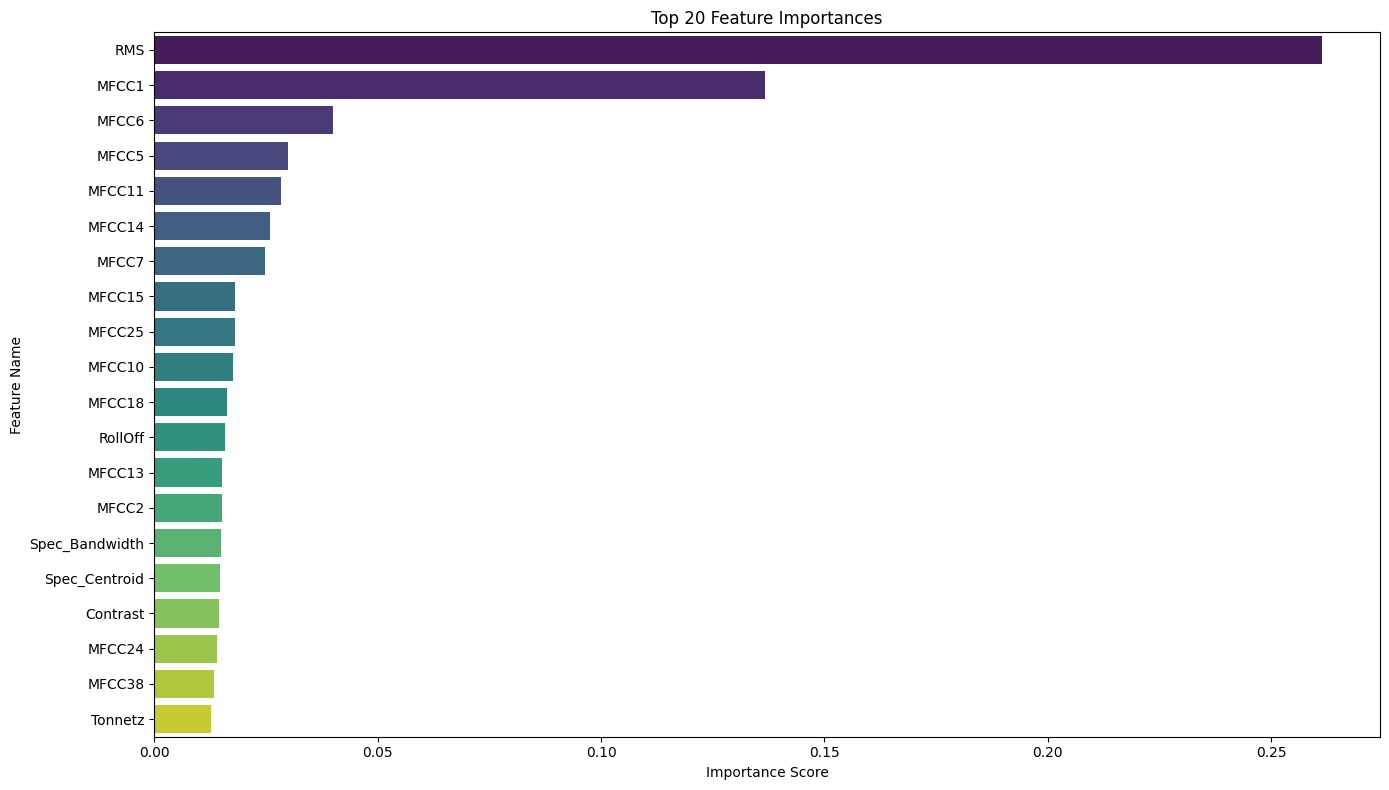

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your trained model: `rf_model` or `best_xgb`
# Use either:
best_xgb = grid.best_estimator_
# importances = rf_model.feature_importances_
importances = best_xgb.feature_importances_  # For XGBoost
# importances = rf_model.feature_importances_  # For Random Forest (uncomment to use RF)

# Create feature name list (match your feature vector size, here assumed 48)
feature_names = [f"MFCC{i}" for i in range(1, 41)] + [
    "Spec_Centroid", "Spec_Bandwidth", "ZCR", "RMS", 
    "RollOff", "Chroma", "Contrast", "Tonnetz"
]

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = np.array(feature_names)[indices]

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], palette='viridis')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


importances = rf_model.feature_importances_  # For Random Forest (uncomment to use RF)

# Create feature name list (match your feature vector size, here assumed 48)
feature_names = [f"MFCC{i}" for i in range(1, 41)] + [
    "Spec_Centroid", "Spec_Bandwidth", "ZCR", "RMS", 
    "RollOff", "Chroma", "Contrast", "Tonnetz"
]

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = np.array(feature_names)[indices]

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], palette='viridis')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

NameError: name 'rf_model' is not defined